<a href="https://colab.research.google.com/github/snehasamanta/TSF7/blob/main/Stock_Market_prediction_using_textual_and_numerical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 7

## Author : SNEHA SAMANTA

# Objective
## Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headline

**Historical stock prices data source : finance.yahoo.com**

**News data source : https://bit.ly/36fFPI6**

# Import important libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import nltk
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Load the SENSEX data

In [2]:
df1=pd.read_csv("/content/drive/MyDrive/datasets/^BSESN.csv")


In [3]:
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-19,24257.279297,24563.339844,24247.230469,24479.839844,24479.839844,9400.0
1,2016-01-20,24325.769531,24325.769531,23839.759766,24062.039063,24062.039063,12800.0
2,2016-01-21,24194.750000,24351.830078,23862.000000,23962.210938,23962.210938,13200.0
3,2016-01-22,24122.060547,24472.880859,24120.039063,24435.660156,24435.660156,10100.0
4,2016-01-25,24540.970703,24650.570313,24433.669922,24485.949219,24485.949219,8900.0


# Extract date frame and plot closing stock price w.r.t time

Text(0.5, 1.0, 'Stock Open Prices')

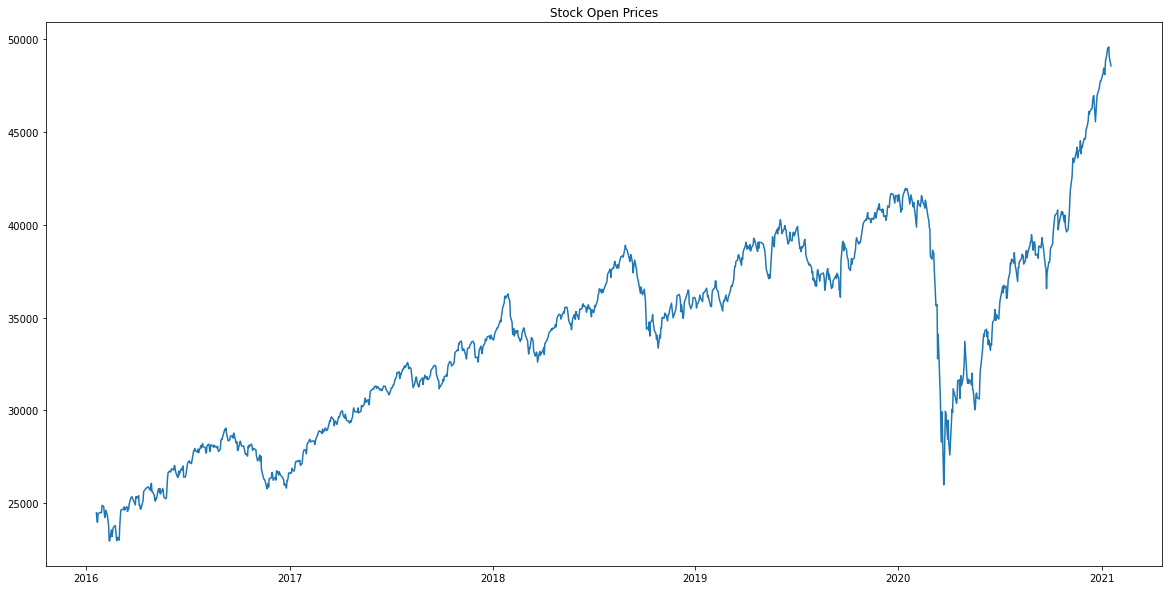

In [4]:
df1['Date'] = pd.to_datetime(df1.Date,format='%Y-%m-%d')
df1.index = df1['Date']
df1.dropna(inplace=True)
#plot
plt.figure(figsize=(20,10))
plt.plot(df1['Close'], label='Close Price history')
plt.title("Stock Open Prices")

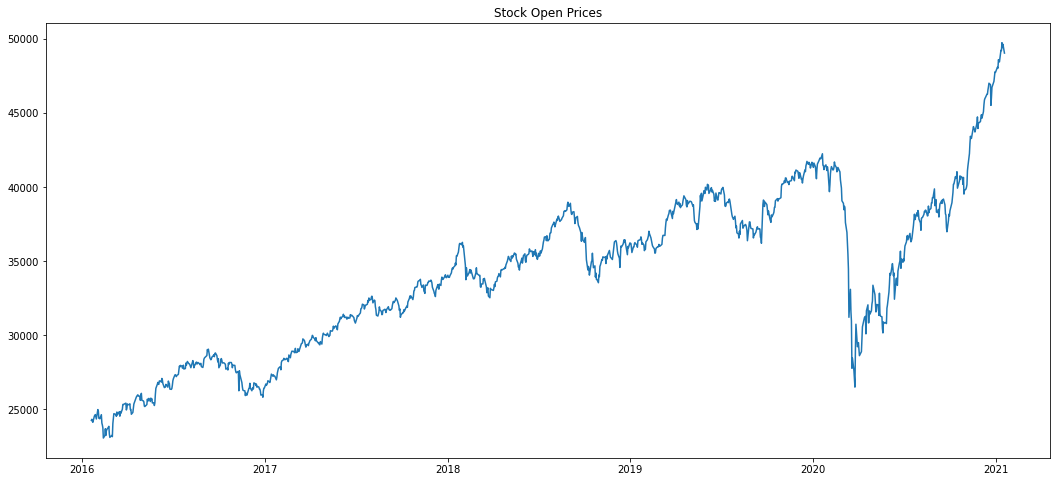

In [7]:
plt.figure(figsize=(18, 8))
plt.plot(df1['Open'])
plt.title("Stock Open Prices")

plt.show()

In [5]:
training_set = df1.iloc[:, 1: 2].values
training_set

array([[24257.279297],
       [24325.769531],
       [24194.75    ],
       ...,
       [49432.828125],
       [49656.710938],
       [49061.21875 ]])

In [6]:
training_set.shape

(1229, 1)

# Data Normalizing

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(np.array(training_set).reshape(-1,1))

In [9]:
training_set_scaled

array([[0.04482135],
       [0.04738619],
       [0.04247974],
       ...,
       [0.98760084],
       [0.99598485],
       [0.97368473]])

In [10]:
df1.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Data splitting

In [11]:
train_size=int(len(training_set_scaled)*0.65)
test_size=len(training_set_scaled)-train_size
train_data,test_data=training_set_scaled[0:train_size,:],training_set_scaled[train_size:len(training_set_scaled),:1]

In [12]:
train_data

array([[0.04482135],
       [0.04738619],
       [0.04247974],
       [0.03975765],
       [0.05544509],
       [0.0592708 ],
       [0.05323147],
       [0.04819286],
       [0.07196912],
       [0.06769965],
       [0.04992594],
       [0.04965853],
       [0.04868152],
       [0.05905657],
       [0.03806458],
       [0.0328769 ],
       [0.02614149],
       [0.        ],
       [0.00610552],
       [0.02352567],
       [0.00662234],
       [0.01782835],
       [0.02171733],
       [0.02707806],
       [0.02958483],
       [0.01020647],
       [0.00167654],
       [0.00302168],
       [0.00666988],
       [0.00348005],
       [0.03687041],
       [0.0496668 ],
       [0.06157233],
       [0.05972238],
       [0.054932  ],
       [0.06573318],
       [0.05841922],
       [0.06520891],
       [0.06634508],
       [0.05531921],
       [0.06709931],
       [0.06250181],
       [0.07291805],
       [0.08503064],
       [0.08469698],
       [0.08825492],
       [0.07103364],
       [0.074

In [13]:
train_data.shape

(798, 1)

# Creating a dataframe for storing the Closing stock data per day

In [14]:
def create_dataset(dataset, time_step=1):
    datax,datay=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        datax.append(a)
        datay.append(dataset[i+time_step,0])
    return np.array(datax),np.array(datay)

In [15]:
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [16]:
X_train

array([[0.04482135, 0.04738619, 0.04247974, ..., 0.127619  , 0.1281519 ,
        0.1288368 ],
       [0.04738619, 0.04247974, 0.03975765, ..., 0.1281519 , 0.1288368 ,
        0.13577371],
       [0.04247974, 0.03975765, 0.05544509, ..., 0.1288368 , 0.13577371,
        0.13456864],
       ...,
       [0.45788304, 0.44135726, 0.45948029, ..., 0.59090029, 0.59667039,
        0.58683379],
       [0.44135726, 0.45948029, 0.45257519, ..., 0.59667039, 0.58683379,
        0.5931128 ],
       [0.45948029, 0.45257519, 0.46204769, ..., 0.58683379, 0.5931128 ,
        0.58273877]])

In [17]:
y_train

array([0.13577371, 0.13456864, 0.128699  , 0.1440644 , 0.13973013,
       0.13828911, 0.12384463, 0.12310802, 0.12546163, 0.1335688 ,
       0.14476655, 0.1499404 , 0.15930656, 0.16029074, 0.15539439,
       0.1584737 , 0.16094645, 0.17253967, 0.1816894 , 0.17965447,
       0.1837116 , 0.18200844, 0.17711735, 0.17657991, 0.18423325,
       0.17455851, 0.17576585, 0.18952464, 0.18408609, 0.18905317,
       0.19370011, 0.18809078, 0.18756797, 0.18529862, 0.18123029,
       0.17788504, 0.19179215, 0.19581038, 0.18997365, 0.17771236,
       0.18198182, 0.1920962 , 0.18729347, 0.18788708, 0.19125815,
       0.18827765, 0.18544995, 0.18742307, 0.1888592 , 0.18058877,
       0.17851076, 0.18544622, 0.19891968, 0.20217167, 0.20365578,
       0.2086195 , 0.22376357, 0.21978624, 0.22478331, 0.20299554,
       0.19791757, 0.19989633, 0.20446392, 0.20844462, 0.21084357,
       0.20574015, 0.21370009, 0.21532463, 0.20860641, 0.19894849,
       0.19242731, 0.20082544, 0.17778279, 0.18487806, 0.19912

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((697, 100), (330, 100), (697,), (330,))

In [19]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

**Tensorflow models**

In [20]:
from tensorflow.keras.layers import Dropout
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
 
regressor.add(LSTM(units = 50, return_sequences = True))

regressor.add(LSTM(units = 50, return_sequences = True))

regressor.add(LSTM(units = 50, return_sequences = False))
 

##add output layer
regressor.add(Dense(units = 1)) 
regressor.compile(loss='mean_squared_error',optimizer='adam')

**Model summary**

In [21]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


**Model training**

In [22]:
regressor.fit(x = X_train, y = y_train, batch_size = 64, epochs = 100,verbose=1)

Epoch 1/100
11/11 [==============================] - 8s 201ms/step - loss: 0.0825
Epoch 2/100
11/11 [==============================] - 2s 202ms/step - loss: 0.0104
Epoch 3/100
11/11 [==============================] - 2s 198ms/step - loss: 0.0046
Epoch 4/100
11/11 [==============================] - 2s 200ms/step - loss: 0.0021
Epoch 5/100
11/11 [==============================] - 2s 195ms/step - loss: 0.0013
Epoch 6/100
11/11 [==============================] - 2s 199ms/step - loss: 9.6238e-04
Epoch 7/100
11/11 [==============================] - 2s 199ms/step - loss: 9.2758e-04
Epoch 8/100
11/11 [==============================] - 2s 201ms/step - loss: 0.0011
Epoch 9/100
11/11 [==============================] - 2s 198ms/step - loss: 0.0010
Epoch 10/100
11/11 [==============================] - 2s 199ms/step - loss: 0.0010
Epoch 11/100
11/11 [==============================] - 2s 203ms/step - loss: 0.0010
Epoch 12/100
11/11 [==============================] - 2s 199ms/step - loss: 9.3793e-04
E

**Predictions**

In [23]:
# make predictions
trainPredict = regressor.predict(X_train)
testPredict = regressor.predict(X_test)

In [24]:
trainPredict

array([[0.14496143],
       [0.14493093],
       [0.14436823],
       [0.14345367],
       [0.14250994],
       [0.14175542],
       [0.14128894],
       [0.14095986],
       [0.14058615],
       [0.14007297],
       [0.1394935 ],
       [0.13908473],
       [0.13910168],
       [0.13979338],
       [0.14127108],
       [0.14342925],
       [0.14608616],
       [0.14904809],
       [0.1522551 ],
       [0.15575194],
       [0.1595049 ],
       [0.16345172],
       [0.16745207],
       [0.17127164],
       [0.17468692],
       [0.17764   ],
       [0.18001369],
       [0.18175685],
       [0.18306628],
       [0.1840884 ],
       [0.18499205],
       [0.18595463],
       [0.1870053 ],
       [0.18809931],
       [0.1891389 ],
       [0.18998443],
       [0.19049767],
       [0.1907986 ],
       [0.19110037],
       [0.19149217],
       [0.19183   ],
       [0.19201931],
       [0.19215243],
       [0.19227807],
       [0.19243045],
       [0.19266926],
       [0.19299006],
       [0.193

In [25]:
testPredict

array([[0.52919775],
       [0.5290063 ],
       [0.52975357],
       [0.5304585 ],
       [0.53042126],
       [0.5288761 ],
       [0.52868104],
       [0.5322322 ],
       [0.5404553 ],
       [0.5524778 ],
       [0.5670737 ],
       [0.582522  ],
       [0.5970951 ],
       [0.6085619 ],
       [0.6159061 ],
       [0.6182271 ],
       [0.61527365],
       [0.6083307 ],
       [0.59881294],
       [0.5884047 ],
       [0.5785943 ],
       [0.57077116],
       [0.5656497 ],
       [0.56388575],
       [0.5656253 ],
       [0.5701666 ],
       [0.5767002 ],
       [0.58424467],
       [0.59197855],
       [0.600208  ],
       [0.6091718 ],
       [0.6186574 ],
       [0.6282537 ],
       [0.63755476],
       [0.6458395 ],
       [0.65291166],
       [0.6585874 ],
       [0.66225636],
       [0.6636185 ],
       [0.6624391 ],
       [0.65918803],
       [0.65450823],
       [0.649062  ],
       [0.6437894 ],
       [0.6393034 ],
       [0.6357437 ],
       [0.63272285],
       [0.630

In [26]:
trainPredict=sc.inverse_transform(trainPredict)
testPredict=sc.inverse_transform(testPredict)

In [27]:
real_stock_price=training_set

**Result visualization**

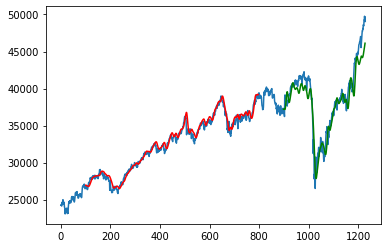

In [28]:
look_back=100
trainPredictPlot = np.empty_like(training_set_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(training_set_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(training_set_scaled)-1, :] = testPredict
# plot baseline and predictions
plt.plot(sc.inverse_transform(training_set_scaled))
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='green')
plt.show()

In [29]:
math.sqrt(mean_squared_error(y_train,trainPredict))

32865.71041060256

In [30]:
math.sqrt(mean_squared_error(y_test,testPredict))

38253.29499548291

In [31]:
# calculate root mean squared error
trainScore = math.sqrt(math.sqrt(mean_squared_error(y_train,trainPredict)))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(math.sqrt(mean_squared_error(y_test,testPredict)))
print("Root mean square error = ",testScore," RMSE")

Root mean square error =  181.28902451776435  RMSE
Root mean square error =  195.5844957952519  RMSE


# Creating a Hybrid model for Numerical and textual Analysis

In [32]:
columns = ['Date','Category','News']
df2=pd.read_csv("/content/drive/MyDrive/datasets/india-news-headlines.csv",names=columns)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
df2.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010101,sports.wwe,win over cena satisfying but defeating underta...
2,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
3,20010102,unknown,Fissures in Hurriyat over Pak visit
4,20010102,unknown,America's unwanted heading for India?


# Text Processing

In [34]:
df2.drop(0, inplace=True)
df2.drop('Category', axis = 1, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 1 to 3297172
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 75.5+ MB


## Restructuring the date format

In [35]:
df2['Date'] = pd.to_datetime(df2['Date'],format= '%Y %m %d')
df2

,Date,News
1,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...
2,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
3,2001-01-02 00:00:00.000000000,Fissures in Hurriyat over Pak visit
4,2001-01-02 00:00:00.000000000,America's unwanted heading for India?
5,2001-01-02 00:00:00.000000000,For bigwigs; it is destination Goa
...,...,...
3297168,1970-01-01 00:00:00.020200630,why tiktok removed 1 65 crore videos in india
3297169,1970-01-01 00:00:00.020200630,apurva asrani calls alia bhatts mother soni ra...
3297170,1970-01-01 00:00:00.020200630,kangana ranaut gets a doll version of herself ...
3297171,1970-01-01 00:00:00.020200630,meezaan jaffrey reminisces his childhood days ...


In [36]:
df2['News'] = df2.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df2 = df2.drop_duplicates() 
df2.reset_index(inplace = True, drop = True)
df2

,Date,News
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...
...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...


In [37]:
df2['News']

0       win over cena satisfying but defeating underta...
1       Status quo will not be disturbed at Ayodhya; s...
2       Powerless north India gropes in the dark Think...
3       The string that pulled Stephen Hawking to Indi...
4       Light combat craft takes India into club class...
                              ...                        
7076    Containment zone residents slam high prices ch...
7077    like me i wont let you have a toxic relationsh...
7078    Atanu Ghosh plans to rewrite old scripts to ma...
7079    6 hot and stylish bikini looks of Katrina Kaif...
7080    Detective Byomkesh Bakshy! Edge of Tomorrow Fi...
Name: News, Length: 7081, dtype: object

In [38]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [39]:
df2['Subjectivity'] = df2['News'].apply(getSubjectivity)
df2['Polarity'] = df2['News'].apply(getPolarity)
df2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,News,Subjectivity,Polarity
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...,0.633333,0.433333
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024
...,...,...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...,0.381841,0.068333
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...,0.398808,0.079290
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956


**Visualizing the polarity and Subjectivity scores**

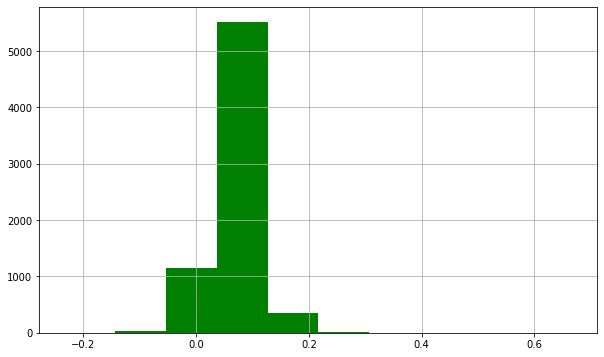

In [40]:
plt.figure(figsize = (10,6))
df2['Polarity'].hist(color = 'green')
plt.show()

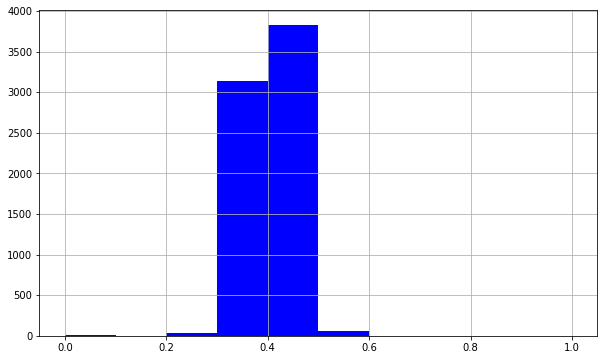

In [41]:
plt.figure(figsize = (10,6))
df2['Subjectivity'].hist(color = 'blue')

**Performing sentiment analysis on New headlines**

In [42]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df2['Compound'] = [sia.polarity_scores(v)['compound'] for v in df2['News']]
df2['Negative'] = [sia.polarity_scores(v)['neg'] for v in df2['News']]
df2['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df2['News']]
df2['Positive'] = [sia.polarity_scores(v)['pos'] for v in df2['News']]
df2

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-01 00:00:00.000000000,win over cena satisfying but defeating underta...,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,2001-01-02 00:00:00.000000000,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,2001-01-03 00:00:00.000000000,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,2001-01-04 00:00:00.000000000,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,2001-01-05 00:00:00.000000000,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
...,...,...,...,...,...,...,...,...
7076,1970-01-01 00:00:00.020200626,Containment zone residents slam high prices ch...,0.381841,0.068333,-0.9999,0.162,0.749,0.089
7077,1970-01-01 00:00:00.020200627,like me i wont let you have a toxic relationsh...,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7078,1970-01-01 00:00:00.020200628,Atanu Ghosh plans to rewrite old scripts to ma...,0.402636,0.057636,-0.9999,0.147,0.779,0.074
7079,1970-01-01 00:00:00.020200629,6 hot and stylish bikini looks of Katrina Kaif...,0.396828,0.061956,-0.9999,0.142,0.773,0.085


In [43]:
dff = df2[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
dff

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.433333,-0.0000,0.230,0.473,0.297
1,0.282333,0.151333,-0.9811,0.122,0.807,0.071
2,0.407692,0.088462,-0.2640,0.122,0.766,0.111
3,0.446847,0.087961,0.8738,0.100,0.797,0.103
4,0.476612,0.262024,0.9633,0.124,0.722,0.154
...,...,...,...,...,...,...
7076,0.381841,0.068333,-0.9999,0.162,0.749,0.089
7077,0.398808,0.079290,-0.9999,0.159,0.749,0.092
7078,0.402636,0.057636,-0.9999,0.147,0.779,0.074
7079,0.396828,0.061956,-0.9999,0.142,0.773,0.085


In [44]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
dff_scaled = pd.DataFrame(sc.fit_transform(dff))
dff_scaled.columns = dff.columns
dff_scaled.index = dff.index
dff_scaled.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.633333,0.740741,0.50000,0.518018,0.473,0.488487
1,0.282333,0.427407,0.00945,0.274775,0.807,0.116776
2,0.407692,0.357550,0.36800,0.274775,0.766,0.182566
3,0.446847,0.356994,0.93690,0.225225,0.797,0.169408
4,0.476612,0.550397,0.98165,0.279279,0.722,0.253289


In [52]:
dff_scaled.shape

(7081, 6)

In [54]:
X = dff_scaled[0:1229]
y =df1['Close']

In [55]:
X.shape

(1229, 6)

In [56]:
y.shape

(1229,)

In [57]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(983, 6)

In [58]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
268,0.378404,0.275640,0.00035,0.391892,0.749,0.125000
1074,0.382508,0.315252,0.00600,0.227477,0.834,0.106908
406,0.366777,0.312481,0.00015,0.463964,0.677,0.192434
554,0.450003,0.344103,0.00095,0.346847,0.738,0.177632
270,0.354092,0.366236,0.00040,0.331081,0.776,0.126645
254,0.456753,0.285996,0.00010,0.479730,0.698,0.146382
58,0.527814,0.328736,0.06340,0.304054,0.768,0.159539
1174,0.382224,0.317822,0.00705,0.277027,0.781,0.157895
869,0.454008,0.447721,0.04550,0.272523,0.756,0.202303
390,0.382817,0.387466,0.00525,0.277027,0.765,0.185855


In [59]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [60]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [61]:
print("Root mean square error = ",math.sqrt(mean_squared_error(prediction,y_test))," RMSE")
print("Root mean square error = ",math.sqrt(mean_squared_error(predictions, y_test))," RMSE")

Root mean square error =  4734.011925134863  RMSE
Root mean square error =  4686.007912348989  RMSE


###  Here, I have used two models, i.e., Random Forest Regressor and Adaboost Regressor to carry out hybrid analysis. From the RMSE values we see that Adaboost gives a mode accurate output (4686 RMSE). However, both the models have very high RMSE values. The reason for high values is the unpredictible nature of the stock prices. The lower the RMSE, it indicates better fit.

**This is the required hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.**